This notebook is used to localize tumor area for `tumor_091.tif`.  

Done(12.19)----------> Improvement:
1. `kp_image.img_to_array()` preprocess images more efficiently. 
2. `np.asarray()` would not copy array like `np.array()`.
3. `model`: VGG16+global pooling 2D instead of flatten layer. 
4. `label2mask`: change i with j because width and height issue.

---

TODO(12.19):
1. **find tissue areas improvement**. (do not use too many non-tissue areas so as to improve performance.)
2. Evaluation: check accuracy! 



In [0]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tensorflow.python.keras.preprocessing import image as kp_image

## Step 0: Download Slide and Show Details

In [0]:
slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [5]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


## Step 1: Read Slide and Preprocess Data

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    return im

In [0]:
def data_aug(x):
  
  #rotate 4 directions and left-right flip
  x1 = np.rot90(x,k=1)
  x2 = np.rot90(x1,k=1)
  x3 = np.rot90(x2,k=1)
  x4 = np.rot90(x3,k=1)
  x5 = x1[:, ::-1]
  x6 = x2[:,::-1]
  x7 = x3[:,::-1]
  x8 = x4[:,::-1]
  x_new= [x1,x2,x3,x4,x5,x6,x7,x8]
  
  return x_new

In [0]:
# # Version 1.0: save images to disk
# def data_preprocess(slide, tumor_mask, level, window_size=(299,299),
#                            center_size=(128,128),stride=128):
  
#   if not os.path.exists('train'): 
#     os.mkdir('train')
#   if not os.path.exists('train/tumor'): 
#     os.mkdir('train/tumor')
#   if not os.path.exists('train/normal'):
#     os.mkdir('train/normal')
  
#   factor = int(slide.level_downsamples[level])
#   tumor_count = 1
#   normal_count = 1
#   x_step = (window_size[0]-center_size[0])//2
#   y_step = (window_size[1]-center_size[1])//2
#   imgs0 = []
#   imgs1 = []
  
#   for i in range(0, slide.level_dimensions[level][0]-window_size[0], stride):  #width
#     for j in range(0, slide.level_dimensions[level][1]-window_size[1], stride):   #height
#       slide_img = read_slide(slide, i*factor, j*factor, level, window_size[0], window_size[1], as_float=False)
#       mask_img = read_slide(tumor_mask, (i+x_step)*factor, (j+y_step)*factor, level, center_size[0], center_size[1], as_float=False)
#       if np.sum(mask_img)==0:   #normal
#         #slide_img.save("train/normal/%d.jpg" % normal_count)
#         #normal_count += 1
#         if np.random.uniform(size=1)>0.6:
#           imgs0.append(kp_image.img_to_array(slide_img)/255)   #np.asarray?
#           #labels.append(0.)
#       elif np.sum(mask_img)!=0: #tumor
#         slide_img.save("train/tumor/%d.jpg" % tumor_count)
#         tumor_count += 1
#         imgs1 += data_aug(kp_image.img_to_array(slide_img)/255)
        
#   imgs = np.concatenate((np.asarray(imgs0),np.asarray(imgs1)))
#   labels = np.append(np.repeat(0.,len(imgs0)),np.repeat(1.,len(imgs1)))
#   ind = [i for i in range(labels.shape[0])]
#   np.random.shuffle(ind)
  
#   return imgs[ind], labels[ind]

In [0]:
# # Version 2.0: don't save, just get array
# def data_preprocess(slide, tumor_mask, level, window_size=(299,299),
#                            center_size=(128,128),stride=128):
  
#   factor = int(slide.level_downsamples[level])
#   tumor_count = 1
#   normal_count = 1
#   x_step = (window_size[0]-center_size[0])//2
#   y_step = (window_size[1]-center_size[1])//2
#   imgs0 = []
#   imgs1 = []
  
#   for i in range(0, slide.level_dimensions[level][0]-window_size[0], stride):  
#     for j in range(0, slide.level_dimensions[level][1]-window_size[1], stride): 
#       slide_img = read_slide(slide, i*factor, j*factor, level, window_size[0], window_size[1], as_float=False)
#       mask_img = read_slide(tumor_mask, (i+x_step)*factor, (j+y_step)*factor, level, center_size[0], center_size[1], as_float=False)
#       if np.sum(mask_img)==0:   #normal
#         if np.random.uniform(size=1)>0.75: #0.75 has to be tuned each time when we change the size!
#           imgs0.append(kp_image.img_to_array(slide_img)/255)  
#       elif np.sum(mask_img)!=0: #tumor
#         imgs1 += data_aug(kp_image.img_to_array(slide_img)/255)
        
#   imgs = np.concatenate((np.asarray(imgs0),np.asarray(imgs1)))
#   labels = np.append(np.repeat(0.,len(imgs0)),np.repeat(1.,len(imgs1)))
#   ind = [i for i in range(labels.shape[0])]
#   np.random.shuffle(ind)
  
#   return imgs[ind], labels[ind]

In [0]:
# Version 3.0: augment all data
def data_preprocess(slide, tumor_mask, level, window_size=(299,299),
                           center_size=(128,128),stride=128):
  
  factor = int(slide.level_downsamples[level])
  tumor_count = 1
  normal_count = 1
  x_step = (window_size[0]-center_size[0])//2
  y_step = (window_size[1]-center_size[1])//2
  imgs0 = []
  imgs1 = []
  
  for i in range(0, slide.level_dimensions[level][0]-window_size[0], stride):  
    for j in range(0, slide.level_dimensions[level][1]-window_size[1], stride): 
      slide_img = read_slide(slide, i*factor, j*factor, level, window_size[0], window_size[1], as_float=False)
      mask_img = read_slide(tumor_mask, (i+x_step)*factor, (j+y_step)*factor, level, center_size[0], center_size[1], as_float=False)
      if np.sum(mask_img)==0:   #normal
        if np.random.uniform(size=1)>0.95: #0.75 has to be tuned each time when we change the size!
          imgs0 += data_aug(kp_image.img_to_array(slide_img)/255)
      elif np.sum(mask_img)!=0: #tumor
        imgs1 += data_aug(kp_image.img_to_array(slide_img)/255)
        
  imgs = np.concatenate((np.asarray(imgs0),np.asarray(imgs1)))
  labels = np.append(np.repeat(0.,len(imgs0)),np.repeat(1.,len(imgs1)))
  ind = [i for i in range(labels.shape[0])]
  np.random.shuffle(ind)
  
  return imgs[ind], labels[ind]

In [0]:
# # Version 4.0: control 1:1 samples
# def data_preprocess(slide, tumor_mask, level, window_size=(299,299),
#                            center_size=(128,128),stride=128):
  
#   factor = int(slide.level_downsamples[level])
#   tumor_count = 1
#   normal_count = 1
#   x_step = (window_size[0]-center_size[0])//2
#   y_step = (window_size[1]-center_size[1])//2
#   imgs0 = []
#   imgs1 = []
  
#   for i in range(0, slide.level_dimensions[level][0]-window_size[0], stride):  
#     for j in range(0, slide.level_dimensions[level][1]-window_size[1], stride): 
#       slide_img = read_slide(slide, i*factor, j*factor, level, window_size[0], window_size[1], as_float=False)
#       mask_img = read_slide(tumor_mask, (i+x_step)*factor, (j+y_step)*factor, level, center_size[0], center_size[1], as_float=False)
#       if np.sum(mask_img)==0:   #normal
#         if np.random.uniform(size=1)>0.5: #0.75 has to be tuned each time when we change the size! 0.95best now
#           imgs0 += data_aug(kp_image.img_to_array(slide_img)/255)
#       elif np.sum(mask_img)!=0: #tumor
#         imgs1 += data_aug(kp_image.img_to_array(slide_img)/255)
  
#   imgs0, imgs1 = np.asarray(imgs0), np.asarray(imgs1)
#   np.random.shuffle(imgs0)
#   imgs = np.concatenate((imgs0[:(imgs1.shape[0])],imgs1))
#   labels = np.append(np.repeat(0.,imgs1.shape[0]),np.repeat(1.,imgs1.shape[0]))
#   ind = [i for i in range(labels.shape[0])]
#   np.random.shuffle(ind)
  
#   return imgs[ind], labels[ind]

In [0]:
window_size=(80,80)
center_size=(50,50)
stride=50
level=3

In [0]:
patches, labels= data_preprocess(slide, tumor_mask, level=3, window_size=window_size,
                           center_size=center_size,stride=stride)

In [14]:
np.unique(labels,return_counts=True)

(array([0., 1.]), array([7928, 3376]))

## Step 2: Train a Model

In [0]:
model = tf.keras.applications.VGG16(input_shape=(299, 299, 3),include_top=False)
model.trainable = False
x = model.output
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_baseline = tf.keras.models.Model(inputs = model.input, outputs = predictions)
model_baseline.compile(loss ="binary_crossentropy",
                       optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001),
                       metrics=["accuracy"])

In [16]:
model_baseline.fit(patches,labels,epochs=8,batch_size=32,validation_split=0.25)

Epoch 1/8
265/265 [==============================] - 62s 235ms/step - loss: 0.3443 - acc: 0.8465 - val_loss: 0.1816 - val_acc: 0.9306
Epoch 2/8
265/265 [==============================] - 58s 218ms/step - loss: 0.2023 - acc: 0.9170 - val_loss: 0.1256 - val_acc: 0.9526
Epoch 3/8
265/265 [==============================] - 58s 217ms/step - loss: 0.1339 - acc: 0.9515 - val_loss: 0.0915 - val_acc: 0.9678
Epoch 4/8
265/265 [==============================] - 57s 217ms/step - loss: 0.1031 - acc: 0.9650 - val_loss: 0.0707 - val_acc: 0.9735
Epoch 5/8
265/265 [==============================] - 57s 216ms/step - loss: 0.1049 - acc: 0.9743 - val_loss: 0.0761 - val_acc: 0.9848
Epoch 6/8
265/265 [==============================] - 57s 216ms/step - loss: 0.0790 - acc: 0.9768 - val_loss: 0.0744 - val_acc: 0.9837
Epoch 7/8
265/265 [==============================] - 57s 216ms/step - loss: 0.0799 - acc: 0.9808 - val_loss: 0.1098 - val_acc: 0.9703
Epoch 8/8
265/265 [==============================] - 57s 216ms

In [0]:
model_baseline.save_weights('baseline_80_50_agu_all.h5')

In [0]:
from google.colab import files
files.download('baseline_80_50_agu_all.h5')

In [0]:
# # if running time died, please run this step after building model directly.
# model_baseline.load_weights('baseline_80_50_agu_all.h5')

## Step 3: Prediction for Trained Slide

In [0]:
## convert labels to mask
def label2mask(y_pred, mask_size, window_size=(150,150),center_size=(100,100),stride=100):
  
  mask_pred=np.zeros((mask_size[1],mask_size[0]))
  count=0
  x_grid=center_size[0]//2
  y_grid=center_size[1]//2
  for j in range(0,mask_size[0]-window_size[0],stride):    
    for i in range(0,mask_size[1]-window_size[1],stride):  
      x_pos=i+window_size[0]//2
      y_pos=j+window_size[1]//2
      if count >= len(y_pred):
        count -= 1
      mask_pred[(x_pos-x_grid):(x_pos+x_grid),(y_pos-y_grid):(y_pos+y_grid)]=y_pred[count]
      count += 1
  return(mask_pred)

In [0]:
# Note: we should get all labels of slide rather than the center region here! 
# Otherwise, we would underestimate our evaluation.
def get_test_pred(model, slide, level, window_size=(299,299),
                     center_size=(128,128),stride=128):
  
  factor = int(slide.level_downsamples[level])
  preds = []
  for i in range(0, slide.level_dimensions[level][0]-window_size[0],stride):  
    for j in range(0, slide.level_dimensions[level][1]-window_size[1],stride): 
      slide_img = read_slide(slide, i*factor, j*factor, level, window_size[0], window_size[1], as_float=False)
      patches = kp_image.img_to_array(slide_img)/255
      y_pred = model.predict(np.expand_dims(patches.astype('float32'),axis=0))
      preds.append(y_pred)
  
  mask_pred = label2mask(np.asarray(preds), slide.level_dimensions[level], window_size = window_size, 
                         center_size=center_size, stride = stride)
  return mask_pred

In [0]:
mask_pred = get_test_pred(model_baseline, slide, level, window_size=window_size,
                          center_size=center_size,stride=stride)

In [0]:
slide_image = np.asarray(read_slide(slide, x=0, y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1]))
mask_image = np.asarray(read_slide(tumor_mask, x=0, y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1]))

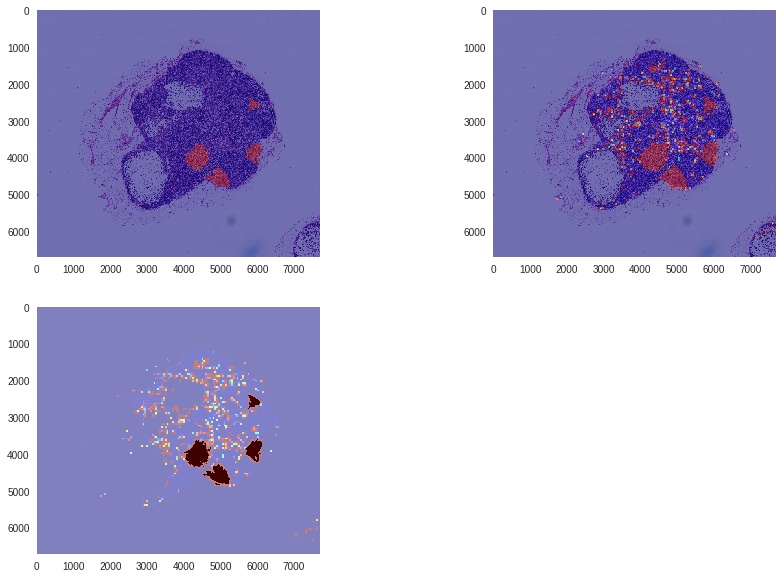

In [24]:
#plt.figure(figsize=(10,10), dpi=50)
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(slide_image)
plt.imshow(mask_image[:,:,0],cmap='jet', alpha=0.5)
plt.grid(False)
plt.subplot(2,2,2)
plt.imshow(slide_image)
plt.imshow(mask_pred, cmap='jet',alpha=0.5) # Red regions contains cancer.
plt.grid(False)
plt.subplot(2,2,3)
plt.imshow(mask_image[:,:,0])
plt.imshow(mask_pred, cmap='jet',alpha=0.5) # Red regions contains cancer.
plt.grid(False)
plt.show()

## Step 4: Prediction for a New Slide

In [0]:
#Download a test slide
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

fname = 'tumor_078.tif'
if not os.path.exists(fname): 
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  f_ = drive.CreateFile({'id': '1cAFgPCkGR0zH0gqCDo4yBnstNoZmjp3C'})
  f_.GetContentFile(fname)
  fname = 'tumor_078_mask.tif'
  f_ = drive.CreateFile({'id': '1ZC2urznY3gRebUG3PN2BtYD1ZPZ7GPYq'})
  f_.GetContentFile(fname)

In [0]:
slide_test_path = 'tumor_078.tif'
test_mask_path = 'tumor_078_mask.tif'
slide_test = open_slide(slide_test_path)
mask_test = open_slide(test_mask_path)

In [0]:
mask_pred_test = get_test_pred(model_baseline, slide_test, level, window_size=window_size,
                               center_size=center_size,stride=stride)

In [0]:
slide_test_image = np.asarray(read_slide(slide_test, x=0, y=0, 
                              level=level, 
                              width=slide_test.level_dimensions[level][0], 
                              height=slide_test.level_dimensions[level][1]))
mask_test_image = np.asarray(read_slide(mask_test, x=0, y=0, 
                             level=level, 
                             width=slide_test.level_dimensions[level][0], 
                             height=slide_test.level_dimensions[level][1]))

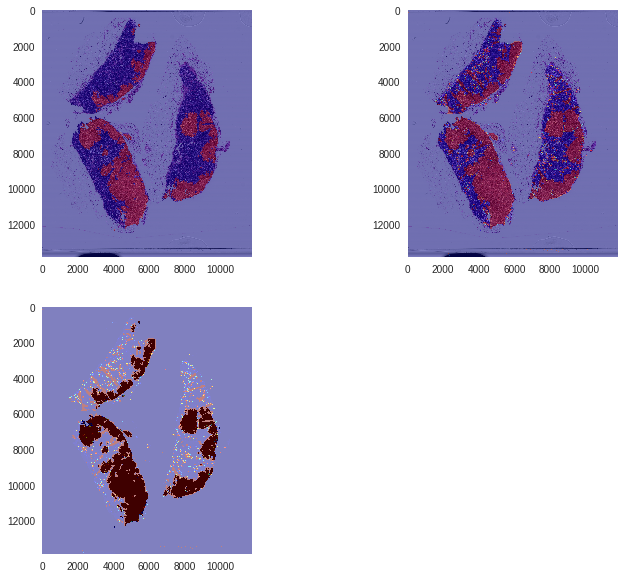

In [29]:
#plt.figure(figsize=(10,10), dpi=50)
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.imshow(slide_test_image)
plt.imshow(mask_test_image[:,:,0],cmap='jet', alpha=0.5)
plt.grid(False)
plt.subplot(2,2,2)
plt.imshow(slide_test_image)
plt.imshow(mask_pred_test, cmap='jet',alpha=0.5) # Red regions contains cancer.
plt.grid(False)
plt.subplot(2,2,3)
plt.imshow(mask_test_image[:,:,0])
plt.imshow(mask_pred_test, cmap='jet',alpha=0.5) # Red regions contains cancer.
plt.grid(False)
plt.show()

In [30]:
import gc
del slide_image, mask_image, patches, labels, mask_pred, slide_test_image
gc.collect()

6910

## Step 5: Evaluation

### Specificity and Sensitivity

Specifity and Sensitivity are not affected by imbalanced data. 

AUC:0.9806940386589096


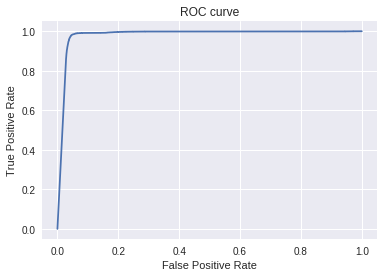

In [31]:
from sklearn import metrics
import sklearn

fpr, tpr, thresholds = metrics.roc_curve(mask_test_image[:,:,0].reshape(-1).astype('float32'), 
                                         mask_pred_test.reshape(-1), pos_label=None)

print('AUC:%s'%(metrics.auc(fpr, tpr)))

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
plt.show()

In [32]:
thres = thresholds[np.argmax(1-fpr+tpr)]
print('Sensitivity:{}'.format(tpr[np.argmax(1-fpr+tpr)]))
print('Specificity:{}'.format((1-fpr)[np.argmax(1-fpr+tpr)]))

Sensitivity:0.9822115347855673
Specificity:0.9520900442555233


### Recall and Precision

In [0]:
#thres = 0.5   #we have to change threshold!

In [0]:
mask_pred_test_labels = np.zeros(mask_pred_test.shape)
mask_pred_test_labels[mask_pred_test > thres] = 1.

In [35]:
thres

0.4707584083080292

In [0]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(mask_test_image[:,:,0].reshape(-1).astype('uint8'), 
                       mask_pred_test_labels.reshape(-1).astype('uint8'))

In [37]:
mat

array([[141265886,   7107910],
       [   271702,  14899590]])

In [0]:
recall = mat[1][1]/(mat[1][1]+mat[1][0])   #tp/tp+fn
precision = mat[1][1]/(mat[1][1]+mat[0][1])  #tp/tp+fp

In [39]:
print('Recall:{}'.format(recall))

Recall:0.9820910440587394


In [40]:
print('Precision:{}'.format(precision))

Precision:0.6770232875156197
